In [1]:
import os
import gc
import mne
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from collections import defaultdict

from threading import Thread
print(__doc__)

Automatically created module for IPython interactive environment


In [7]:
autodfname = 'auto_path_table.json'
autodf = pd.read_json(autodfname)
autodf

,emnoises,raws,restings
EEG_S01,[],"{'10': '20190402_RSVP_EEG_S01/10.cnt', '02': '...",[]
EEG_S02,[],"{'10': '20190402_RSVP_EEG_S02/10.cnt', '02': '...",[]
EEG_S03,[],"{'10': '20191230_RSVP_EEG_S03/10.cnt', '11': '...","[20191230_RSVP_EEG_S03/r1.cnt, 20191230_RSVP_E..."
EEG_S04,[],"{'10': '20200104_RSVP_EEG_S04/10.cnt', '11': '...","[20200104_RSVP_EEG_S04/r1.cnt, 20200104_RSVP_E..."
EEG_S05,[Noise-default_Noise_20200107_02.ds],"{'10': '20200107-RSVP_EEG_S05/10.cnt', '11': '...","[20200107-RSVP_EEG_S05/r1.cnt, 20200107-RSVP_E..."
EEG_S06,[],"{'10': '20200106_RSVP_EEG_S06/10.cnt', '11': '...","[20200106_RSVP_EEG_S06/r1.cnt, 20200106_RSVP_E..."
EEG_S07,[],"{'10': '20200106_RSVP_EEG_S07/10.cnt', '11': '...","[20200106_RSVP_EEG_S07/r1.cnt, 20200106_RSVP_E..."
EEG_S08,[],"{'10': '20200111-RSVP_EEG_S08/10.cnt', '11': '...","[20200111-RSVP_EEG_S08/r1.cnt, 20200111-RSVP_E..."
EEG_S09,[],"{'10': '20200104_RSVP_EEG_S09/10.cnt', '11': '...","[20200104_RSVP_EEG_S09/r1.cnt, 20200104_RSVP_E..."
MEG_S01,"[Noise-default_Noise_20190326_01.ds, Noise-def...",{'04': '20190326_RSVP_MEG_S01/S01_lixiangTHU_2...,[20190326_RSVP_MEG_S01/rS01-resting_lixiangTHU...


In [3]:
iter_freqs = [
    ('Delta', 1, 4),
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
#     ('Gamma', 30, 45),
    ('Cb_U04', 0.1, 4),
    ('Cb_U07', 0.1, 7),
    ('Cb_U12', 0.1, 12),
    ('Cb_U30', 0.1, 30),
]

tmin, tmax = -0.2, 1.2

In [4]:
n_jobs = 48

# time_decoder = mne.decoding.SlidingEstimator(clf, n_jobs=n_jobs, scoring='f1')
skf = StratifiedKFold(n_splits=10)


def xdawn_fit_predict(y_predict, epochs, y, train, test):
    print('xdawn_fit_predict starts.')
    # Init xdawn
    xdawn = mne.preprocessing.Xdawn(n_components=6, reg='diagonal_fixed')
    
    # Init classifier
    _svm = svm.SVC(gamma='scale', kernel='rbf', class_weight='balanced')
    clf = make_pipeline(StandardScaler(), _svm)
    classifier = make_pipeline(mne.decoding.Vectorizer(), clf)
    
    # Fit xdawn
    xdawn.fit(epochs[train])
    # Transoform using xdawn
    X_train, y_train = xdawn.apply(epochs[train])['1'].get_data(), y[train]
    X_test, y_test = xdawn.apply(epochs[test])['1'].get_data(), y[test]
    
    # Train clasifier
    print('Training.')
    classifier.fit(X_train, y_train)
    # Predict
    print('Predicting.')
    y_predict[test] = classifier.predict(X_test)
    
    # del epochs, X_train, X_test, y_train, y_test, xdawn, _svm
    # gc.collect()
    print('xdawn_fit_predict ends.')
    

    
def perform_MVPA(epochs, CV=skf):
    # MVPA method for epochs
    # CV: cross-validation generator
    
    epochs.baseline = None
    
    # Get X, y
    X = epochs.get_data()
    events = epochs.events
    y = events[:, -1]
    print(X.shape, y.shape)
    
    # Prepare predicts
    y_predict = np.zeros(X.shape[0])
    y_time_predict = np.zeros((X.shape[0], X.shape[2]))
    print(y_predict.shape, y_time_predict.shape)
    
    # Cross validation
    threads = []
    # Split train and test
    for train, test in CV.split(X, y):
        threads.append(Thread(target=xdawn_fit_predict,
                              args=(y_predict, epochs.copy(), y, train, test)))
    
    for j in range(2):
        for k in range(5):
            threads[j*5+k].start()
        for k in range(5):
            threads[j*5+k].join()

    # Return
    return dict(
        y_true = y,
        y_predict = y_predict,
        y_time_predict = y_time_predict,
        times = epochs.times,
    )

def report_MVPA(predicts):
    y_true = predicts['y_true']
    y_pred = predicts['y_predict']
    #     y_time_pred = predicts['y_time_predict']
    # All time report
    print(sklearn.metrics.classification_report(y_pred=y_pred, y_true=y_true))
    print(sklearn.metrics.precision_score(y_pred=y_pred, y_true=y_true, average='weighted'))
    # Window time report
    #     scores = np.zeros(y_time_pred.shape[1])
    #     for j, y_pred in enumerate(y_time_pred.transpose()):
    #         scores[j] = sklearn.metrics.precision_score(y_pred=y_pred, y_true=y_true, average='weighted')
    #     plt.plot(scores)

--------------------------------------------------------------------------------
EEG_S01
--------------------------------------------------------------------------------
EEG_S02
--------------------------------------------------------------------------------
EEG_S03
--------------------------------------------------------------------------------
EEG_S04
--------------------------------------------------------------------------------
EEG_S05
Opening raw data file processed_data/EEG_S05/block_06_ica-raw.fif...
Isotrak not found
    Range : 0 ... 199839 =      0.000 ...   199.839 secs
Ready.
Opening raw data file processed_data/EEG_S05/block_10_ica-raw.fif...
Isotrak not found
    Range : 0 ... 201239 =      0.000 ...   201.239 secs
Ready.
Opening raw data file processed_data/EEG_S05/block_05_ica-raw.fif...
Isotrak not found
    Range : 0 ... 203199 =      0.000 ...   203.199 secs
Ready.
Opening raw data file processed_data/EEG_S05/block_08_ica-raw.fif...
Isotrak not found
    Range : 0 .

Index: 2026142: 100%|██████████| 560/560 [00:24<00:00, 22.96it/s]


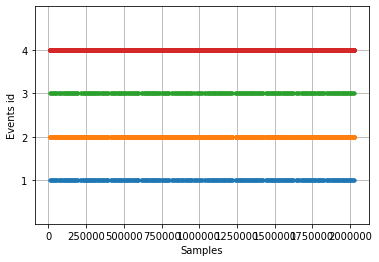

--------------------------------------------------------------------------------
('Delta', 1, 4)
Reading 0 ... 2031759  =      0.000 ...  2031.759 secs...
Filtering raw data in 10 contiguous segments
Setting up band-pass filter from 1 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 3301 samples (3.301 sec)



[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  30 out of  64 | elapsed:    2.9s remaining:    3.3s
[Parallel(n_jobs=48)]: Done  43 out of  64 | elapsed:    3.0s remaining:    1.4s
[Parallel(n_jobs=48)]: Done  56 out of  64 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=48)]: Done  64 out of  64 | elapsed:    3.1s finished


14549 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 3410 events and 1401 original time points ...
0 bad epochs dropped


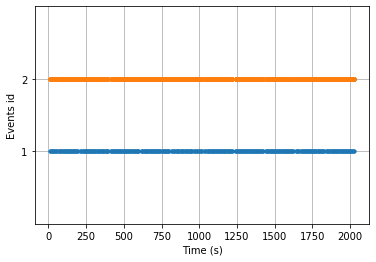

{'1': 1, '2': 2}
1


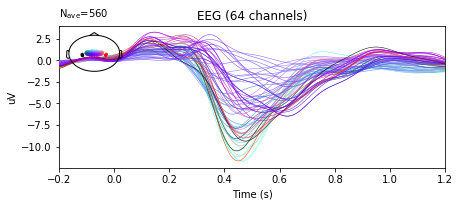

2


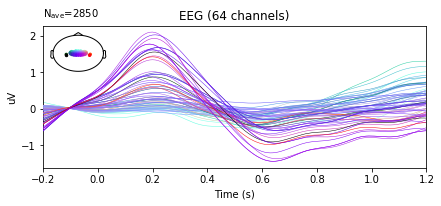

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Computing data rank from raw with rank='full'
    EEG: rank 64 from info
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.Training.

Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.85      0.87      0.86       560
           2       0.97      0.97      0.97      2850


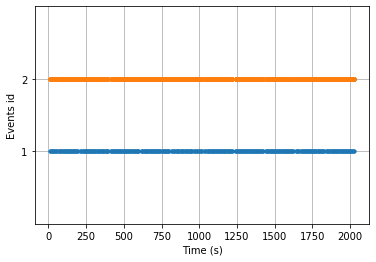

{'1': 1, '2': 2}
1


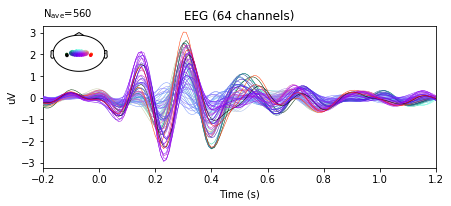

2


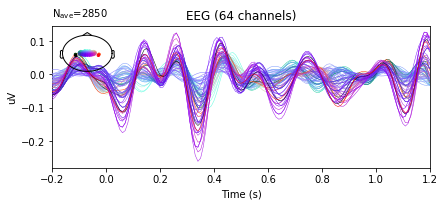

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.xdawn_fit_predict starts.

xdawn_fit_predict starts.xdawn_fit_predict starts.

xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.79      0.71      0.75       560
           2       0.94      0.96      0.95      2850

    accuracy                           0.92      3410
   macro avg      

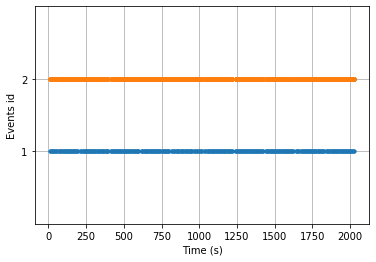

{'1': 1, '2': 2}
1


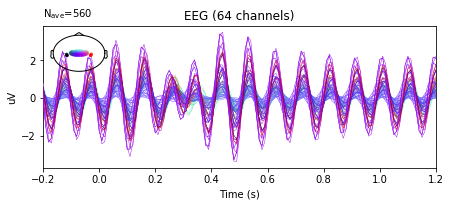

2


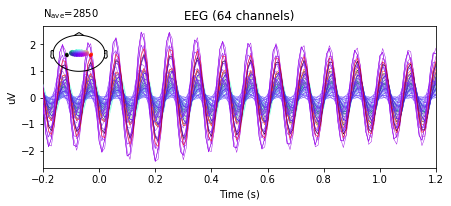

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.xdawn_fit_predict starts.

xdawn_fit_predict starts.xdawn_fit_predict starts.

xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.Predicting.

Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.38      0.60      0.46       560
           2       0.91      0.80      0.85      2850

    accuracy                           0.77      3410
   macro avg      

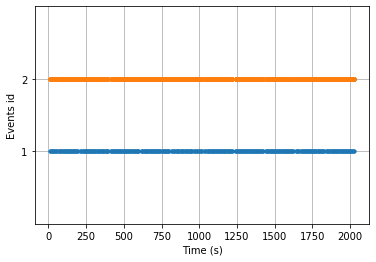

{'1': 1, '2': 2}
1


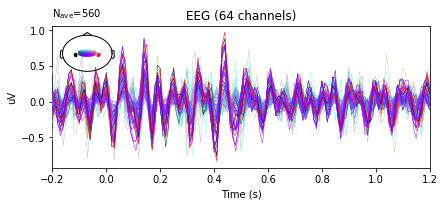

2


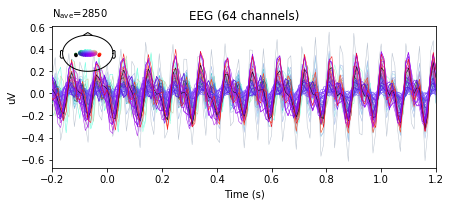

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.xdawn_fit_predict starts.

xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.Training.

Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.38      0.23      0.28       560
           2       0.86      0.93      0.89      2850

    accuracy                           0.81      3410
   macro avg      

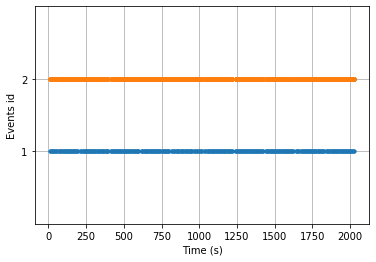

{'1': 1, '2': 2}
1


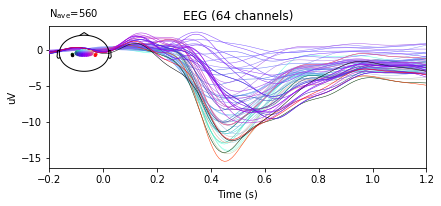

2


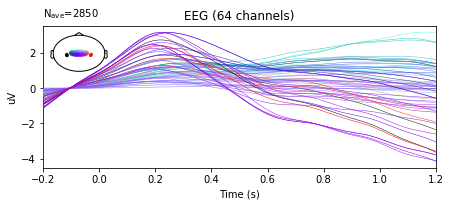

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.xdawn_fit_predict starts.

Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.Training.

Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.73      0.85      0.79       560
           2       0.97      0.94      0.95      2850

    accuracy                           0.92      3410
   macro avg      

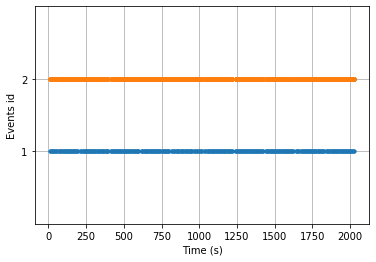

{'1': 1, '2': 2}
1


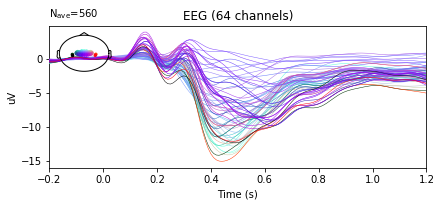

2


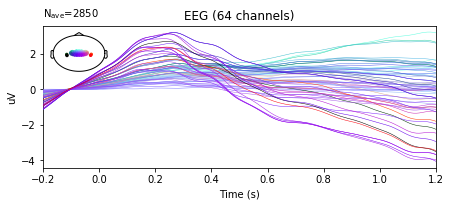

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.xdawn_fit_predict starts.

xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.75      0.84      0.79       560
           2       0.97      0.95      0.96      2850

    accuracy                           0.93      3410
   macro avg      

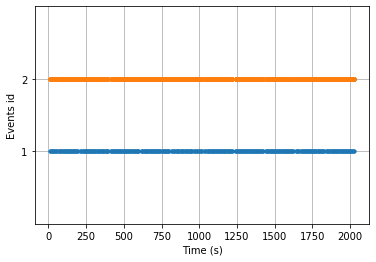

{'1': 1, '2': 2}
1


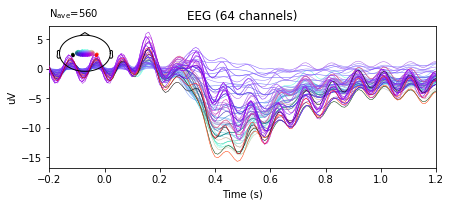

2


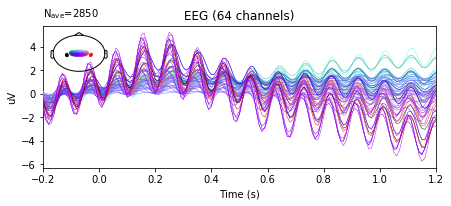

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.75      0.83      0.79       560
           2       0.97      0.95      0.96      2850

    accuracy                           0.93      3410
   macro avg      

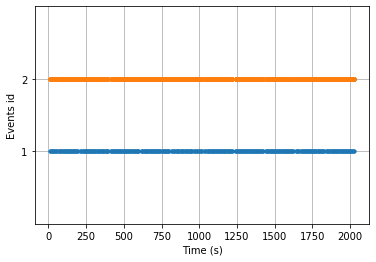

{'1': 1, '2': 2}
1


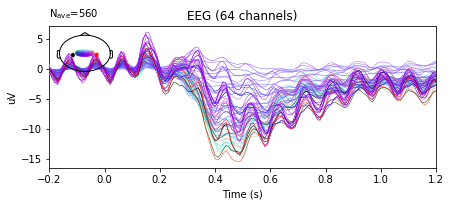

2


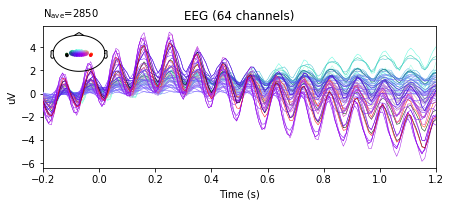

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.xdawn_fit_predict starts.

xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.Training.

Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.78      0.83      0.81       560
           2       0.97      0.95      0.96      2850

    accuracy                           0.93      3410
   macro avg      

Index: 1925833: 100%|██████████| 560/560 [00:25<00:00, 22.26it/s]


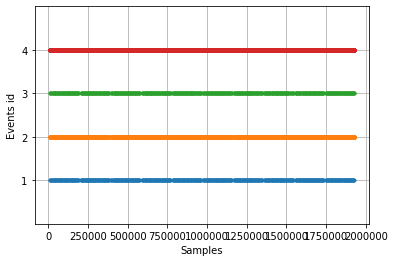

--------------------------------------------------------------------------------
('Delta', 1, 4)


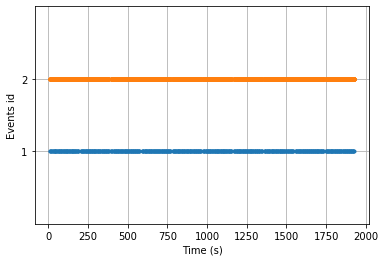

{'1': 1, '2': 2}
1


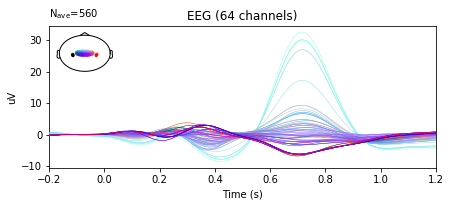

2


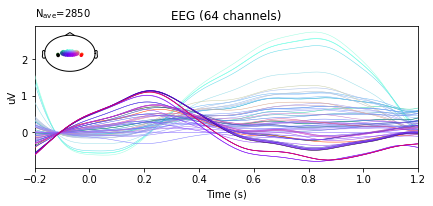

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.xdawn_fit_predict starts.
xdawn_fit_predict starts.

xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.xdawn_fit_predict starts.

Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.77      0.85      0.81       560
           2       0.97      0.95      0.96      2850

    accuracy                           0.93      3410
   macro avg      

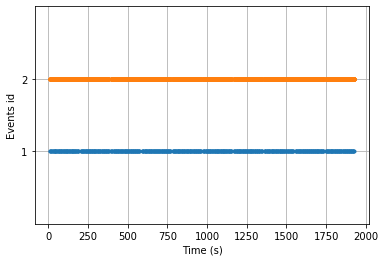

{'1': 1, '2': 2}
1


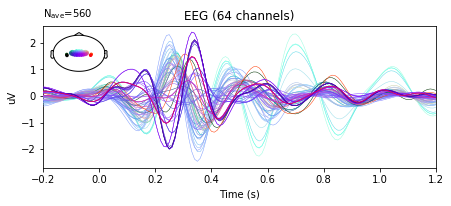

2


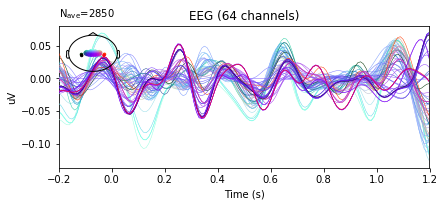

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.xdawn_fit_predict starts.

xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.80      0.77      0.78       560
           2       0.96      0.96      0.96      2850

    accuracy                           0.93      3410
   macro avg      

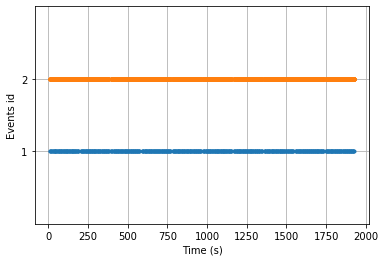

{'1': 1, '2': 2}
1


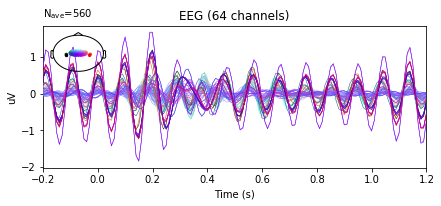

2


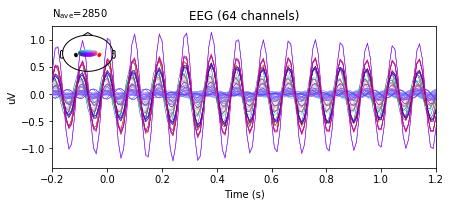

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.Predicting.

Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.54      0.56      0.55       560
           2       0.91      0.90      0.91      2850

    accuracy                           0.85      3410
   macro avg      

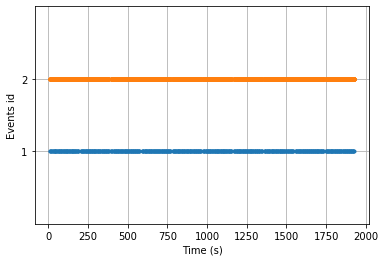

{'1': 1, '2': 2}
1


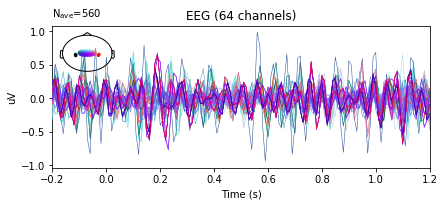

2


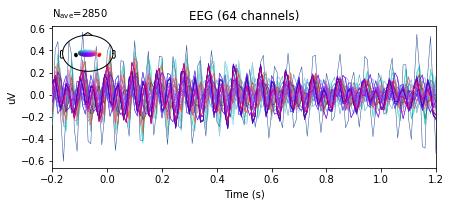

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.xdawn_fit_predict starts.

xdawn_fit_predict starts.xdawn_fit_predict starts.

xdawn_fit_predict starts.
Training.Training.

Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.33      0.14      0.20       560
           2       0.85      0.94      0.89      2850

    accuracy                           0.81      3410
   macro avg      

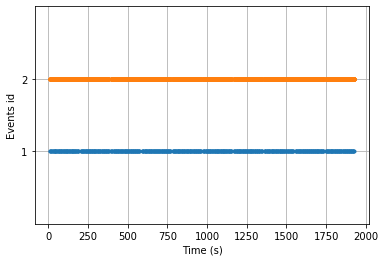

{'1': 1, '2': 2}
1


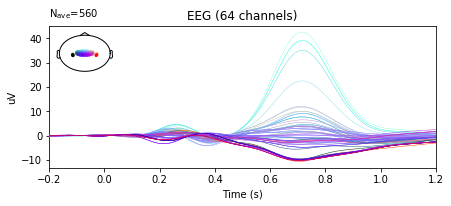

2


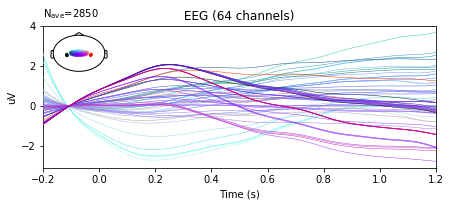

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.Predicting.

xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
Predicting.
xdawn_fit_predict ends.
Predicting.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.70      0.84      0.76       560
           2       0.97      0.93      0.95      2850

    accuracy                           0.91      3410
   macro avg      

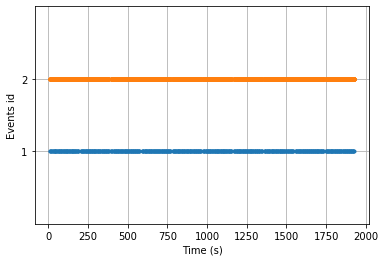

{'1': 1, '2': 2}
1


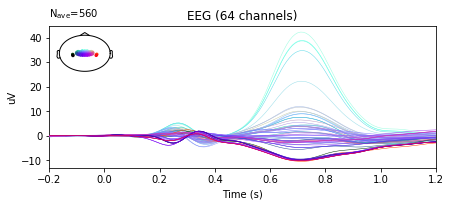

2


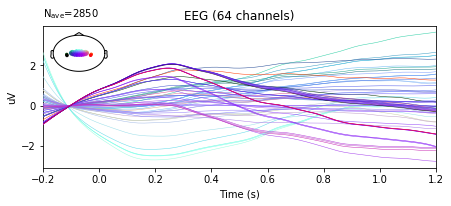

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.xdawn_fit_predict starts.

xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
xdawn_fit_predict ends.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.Predicting.

xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
Predicting.
xdawn_fit_predict ends.
Predicting.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.70      0.83      0.76       560
           2       0.97      0.93      0.95      2850

    accuracy                           0.91      3410
   macro avg      

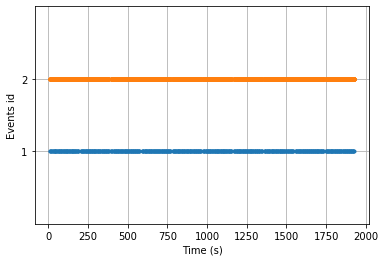

{'1': 1, '2': 2}
1


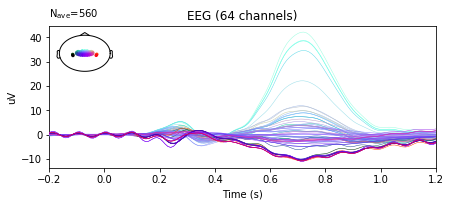

2


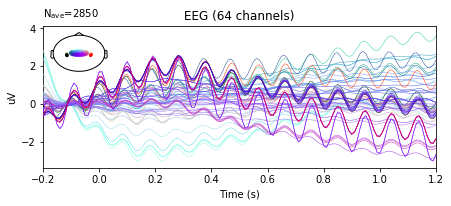

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
Predicting.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.70      0.82      0.76       560
           2       0.96      0.93      0.95      2850

    accuracy                           0.91      3410
   macro avg      

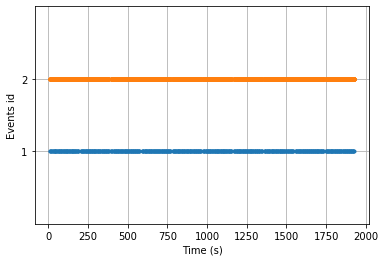

{'1': 1, '2': 2}
1


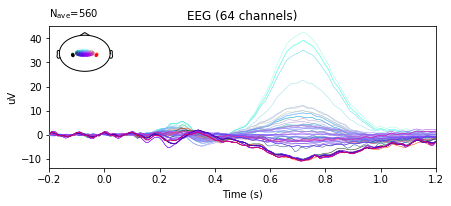

2


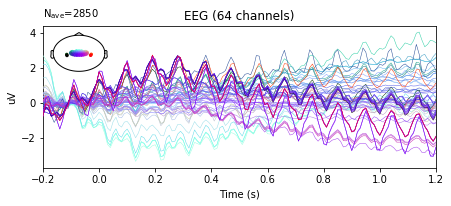

(3410, 64, 141) (3410,)
(3410,) (3410, 141)
xdawn_fit_predict starts.xdawn_fit_predict starts.

xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
xdawn_fit_predict starts.
Training.
Training.
Training.
Training.
Training.
Predicting.
Predicting.
Predicting.
Predicting.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
xdawn_fit_predict ends.
Predicting.
xdawn_fit_predict ends.
              precision    recall  f1-score   support

           1       0.69      0.81      0.75       560
           2       0.96      0.93      0.95      2850

    accuracy                           0.91      3410
   macro avg      

In [5]:
for exper in autodf.index:
    print('-' * 80)
    print(exper)
    if os.path.exists('MVPA_predicts_{}.json'.format(exper)):
        continue
    rawraw = mne.concatenate_raws([mne.io.read_raw_fif(os.path.join('processed_data', exper, e)) for e in os.listdir(os.path.join('processed_data', exper)) if e.endswith('_ica-raw.fif')])

    MVPA_predict_df = pd.DataFrame()

    # Filter events
    events = False
    if exper.startswith('MEG'):
        picks = 'mag'
        decim = 12
        events = mne.find_events(rawraw, stim_channel='UPPT001')
    if exper.startswith('EEG'):
        picks = 'eeg'
        decim = 10
        events = mne.events_from_annotations(rawraw)[0]
    assert(events is not False)
    
    sfreq = rawraw.info['sfreq']
    with tqdm.tqdm(events[events[:, -1]==1]) as pbar:
        for e in pbar:
            pbar.set_description('Index: {}'.format(e[0]))
            for ee in events:
                if all([ee[-1] == 2, abs(ee[0]-e[0])<sfreq]):
                    ee[-1] = 4
    mne.viz.plot_events(events)

    for freqs in iter_freqs:
        print('-' * 80)
        print(freqs)
        name_freq, l_freq, h_freq = freqs
        
        # Copy raw and filter rr
        rr = rawraw.copy()
        rr.load_data()
        rr.filter(l_freq=l_freq, h_freq=h_freq, n_jobs=n_jobs)

        # Get epochs
        # Raw epochs
        epochs = mne.Epochs(rr, events, picks=picks, tmin=tmin, tmax=tmax, decim=decim)
        # Clear events
        epochs = epochs[['1', '2']]
        epochs.load_data()

        event_id = epochs.event_id
        # Get and plot events
        events = epochs.events
        mne.viz.plot_events(events, sfreq=sfreq)
        print(event_id)
        # Plot epochs
        for event in event_id:
            print(event)
            epochs[event].average().plot(spatial_colors=True)

        # perform MVPA
        # MVPA_predicts = perform_MVPA(epochs.copy())
        # Report MVPA
        # report_MVPA(MVPA_predicts)
        # MVPA_results[name_freq].append(('origin', MVPA_predicts))

        # perform xdawn MVPA
        xdawn_MVPA_predicts = perform_MVPA(epochs.copy())
        # Report xdawn MVPA
        report_MVPA(xdawn_MVPA_predicts)
        
        MVPA_predict_df = MVPA_predict_df.append(pd.Series(xdawn_MVPA_predicts, name=name_freq))

    MVPA_predict_df.to_json('MVPA_predicts_{}.json'.format(exper))